# Eigenfaces

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from rputil import *
from PIL import Image
import glob
from time import time, perf_counter

from tqdm import notebook

from rputil import *

%matplotlib inline

In [2]:
n_images = 1000

data = np.empty((62500, n_images), dtype='uint8')

for i,filename in notebook.tqdm(enumerate(glob.iglob('lfw-funneled/lfw_funneled/**/*.jpg', recursive = True))):  #images are 250x250x3
    if i >= n_images:
        break
    im=Image.open(filename)
    arr = np.asarray(im, dtype='uint8')[:,:,0].flatten()
    data[:,i] = arr
    im.close()


In [3]:
data = data - np.expand_dims(np.mean(data, axis=1),1)

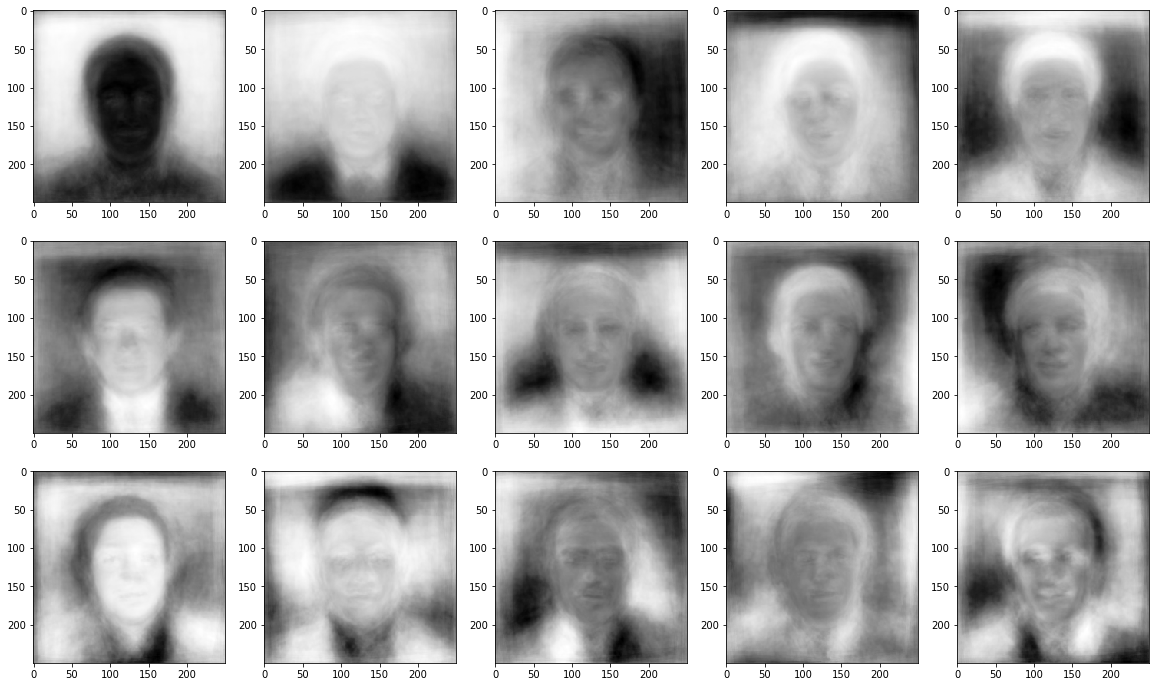

In [11]:
def svd_factor(A, k, full=False):
    start = time()
    u, sigma, vh = np.linalg.svd(A, full_matrices=False) #compute svd
    end = time()
    if full:
        return u[:,:k] @ np.diag(sigma[:k]) @ vh[:k], end - start
    else:
        return u[:,:k]

rows, cols = (3,5)

start = perf_counter()
basis = svd_factor(data, rows*cols)
end = perf_counter()
t1 = end - start

fig, ax = plt.subplots(rows, cols, figsize=(20, 20 * rows / cols))
for i in range(rows):
    for j in range(cols):
        ax[i][j].imshow(basis[:,i * cols + j].reshape(250,250), cmap='Greys')


In [5]:
basis

array([[-0.00270972,  0.0010291 , -0.00411341, ..., -0.00314056,
        -0.00100732, -0.00290945],
       [-0.00278639,  0.00104604, -0.00422602, ..., -0.00303422,
        -0.0008983 , -0.00321224],
       [-0.00296687,  0.00098095, -0.00436063, ..., -0.0028821 ,
        -0.0012344 , -0.00324486],
       ...,
       [-0.00136795,  0.00614907,  0.0009396 , ..., -0.00086972,
         0.002863  ,  0.00965066],
       [-0.00144399,  0.0059962 ,  0.0007635 , ..., -0.00097049,
         0.00300983,  0.00951611],
       [-0.00147166,  0.00565395,  0.00076633, ..., -0.00139208,
         0.0031519 ,  0.00927614]])

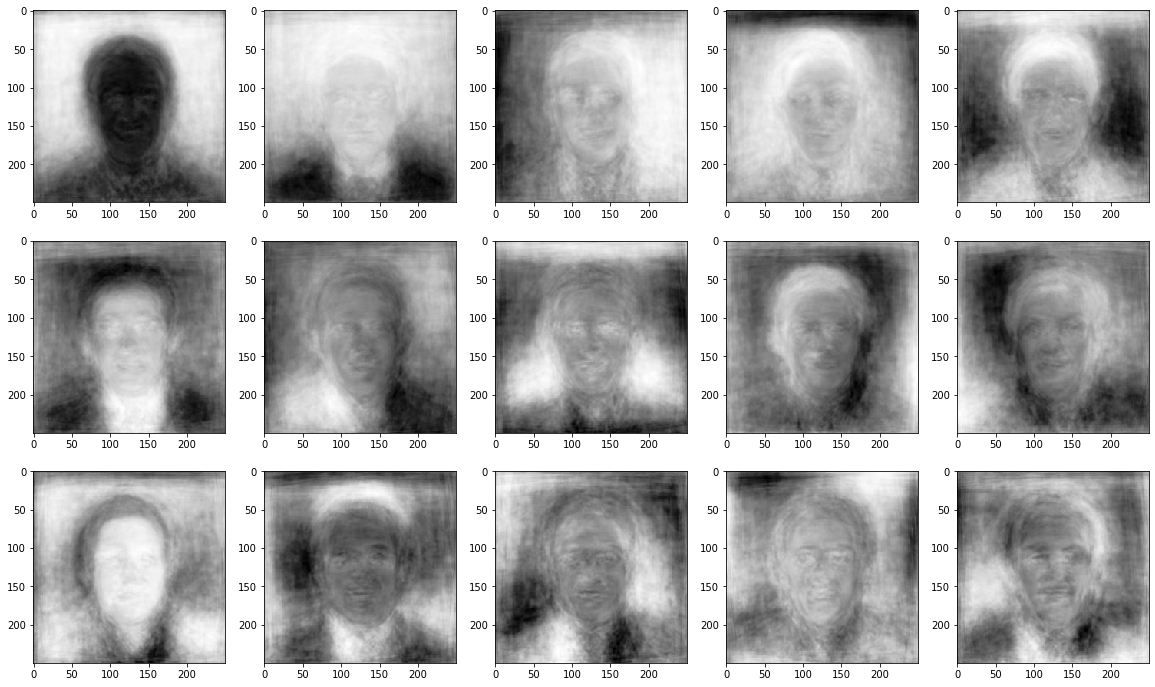

In [6]:
def rsvd_factor(A, rank, k, full=False): 
    start = time()
    omega = random.randn(A.shape[1],rank)
    Y = A @ omega
    Q, R = np.linalg.qr(Y)
    B = Q.T @ A
    U_tilde, Sigma, Vh = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde
    end = time()
    if full:
        return U @ np.diag(Sigma) @ Vh, end - start
    else:
        return U[:,:k]

rows, cols = (3,5)

start = perf_counter()
basis = rsvd_factor(data, n_images // 4, rows*cols)
end = perf_counter()
t2 = end - start

fig, ax = plt.subplots(rows, cols, figsize=(20, 20 * rows / cols))
for i in range(rows):
    for j in range(cols):
        ax[i][j].imshow(basis[:,i * cols + j].reshape(250,250), cmap='Greys')


In [7]:
print(f"SVD time : {t1}. RSVD time: {t2}")

SVD time : 21.619452600000002. RSVD time: 4.631894599999999


In [19]:
domain = np.asarray([16, 32, 64, 128, 256, 512])

svd_values, svd_cost = svd_factor(data, 1, full=True)


errors = np.empty(domain.shape)
costs = np.empty(domain.shape)

for i in range(domain.shape[0]):
    output, costs[i] = rsvd_factor(data, domain[i], 1, full=True)
    errors[i] = np.linalg.norm(output - svd_values) / np.linalg.norm(svd_values)


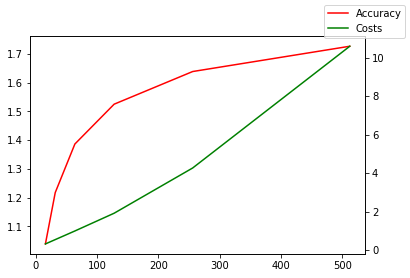

In [20]:
fig, ax = plt.subplots()

ax.plot(domain,errors, c='r', label='Accuracy')

ax2 = ax.twinx()

ax2.plot(domain,costs, c='g', label='Costs')


fig.legend(loc='upper right')